## Tech Challenge - Fase 2


####Dicionário das features da base de dados
*   **data:** data da amostragem
*   **ultimo:** valor final em que fechou a bolsa
*   **abertura:** valor inicial quando abriu a bolsa
*   **maxima:** valor máximo alcançado naquele dia
*   **minima:** valor mínimo alcançado naquele dia
*   **volume:** a quantidade total de ativos financeiros que foram negociados durante um determinado período, neste caso, durante um dia
*   **variacao:** percentual de variacao do ultimo do dia anterior comparado ao ultimo do dia atual. (%) Calcula-se com o mais recente/menos recente. Exemplo, dividindo 133,533/132,753 temos 1,0059... multiplica-se por 100 para capturar a porcentagem somente após o número 1.Ou seja, aumentou 0,59%(número positivo por causa do 1 na frente, se fosse com o 0 na frente, entao teríamos que colocar um sinal de negativo e também subtrair o valor encontrado de 1)

### Obtendo os dados

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
df =  pd.read_csv("/content/drive/MyDrive/Tech Challenges/Fase 2/Base dados/8 anos com pandemia/Dados Históricos - Ibovespa.csv", sep=',');
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,28.12.2023,134.185,134.194,134.389,133.832,"7,81M","-0,01%"
1,27.12.2023,134.194,133.523,134.195,133.328,"6,17M","0,49%"
2,26.12.2023,133.533,132.753,133.645,132.753,"5,15M","0,59%"
3,22.12.2023,132.753,132.182,133.035,132.094,"8,23M","0,43%"
4,21.12.2023,132.182,130.826,132.277,130.822,"8,68M","1,05%"


###Análise Exploratória e Tratamento de Dados

In [4]:
df.rename(columns={"Data":"data", "Último":"ultimo", "Abertura":"abertura", "Máxima":"maxima", "Mínima":"minima", "Vol.": "volume", "Var%":"variacao" }, inplace=True)

In [5]:
df.shape

(1982, 7)

In [6]:
df.isnull().sum()

data        0
ultimo      0
abertura    0
maxima      0
minima      0
volume      1
variacao    0
dtype: int64

In [7]:
df.dropna(inplace=True)

O dado nulo encontrado diz respeito ao dia 10/02/2016.
Possíveis motivos:

1. Problemas Técnicos: Pode haver problemas técnicos ou falhas na coleta e atualização de dados. Às vezes, esses problemas podem resultar na ausência de dados para determinadas datas.

2. Feriado ou Suspensão do Mercado: Se 10/02/2016 foi um feriado ou se houve uma suspensão do mercado naquela data, isso poderia explicar a ausência de dados de volume.

3. Erro na Fonte de Dados: Pode haver um erro na fonte de dados em questão. As plataformas online que fornecem dados financeiros podem ocasionalmente apresentar erros ou falhas.

O dia 10/02/2016 foi uma quarta-feira de cinzas, podendo ser esta a causa da ausência de dados de volume neste dia.
Obs.: porque nos os outros anos não tem esse valor nulo no ponto facultativo da quarta-feira de cinzas?

https://br.advfn.com/indice/ibovespa/2016/02:

10 de Fevereiro de 2016 – Fed e Carnaval fazem Ibovespa amargar segunda queda consecutiva neste mini pregão de Quarta-Feira de Cinzas

O clima no principal mercado acionário do Brasil foi de pessimismo na volta do feriado de Carnaval. Após dois dias sem abrir, as ações brasileiras tiveram que se ajustar às quedas registradas por suas ADRs negociadas na Bolsa de Valores de Nova Iorque. American Depositary Receipts (ADRs) são recibos de ações de empresas estrangeiras negociadas no mercado acionário dos Estados Unidos. Os investidores também se decepcionaram com os comentários da presidente do Federal Reserve (Fed), banco central norte-americano, de que a instituição pretende realizar alguns ajustes em sua política monetária nas próximas reuniões com seus presidentes regionais. Tudo isso pesou, fazendo com que o principal índice de ações do país encerrasse o Carnaval em baixa, a segunda desvalorização consecutiva.

In [8]:
df.isnull().sum()

data        0
ultimo      0
abertura    0
maxima      0
minima      0
volume      0
variacao    0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1981 entries, 0 to 1981
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   data      1981 non-null   object 
 1   ultimo    1981 non-null   float64
 2   abertura  1981 non-null   float64
 3   maxima    1981 non-null   float64
 4   minima    1981 non-null   float64
 5   volume    1981 non-null   object 
 6   variacao  1981 non-null   object 
dtypes: float64(4), object(3)
memory usage: 123.8+ KB


####Transformando a coluna 'data' para DateTime para facilitar as análises


In [10]:
df['data'] = pd.to_datetime(df['data'])
df.head()

<ipython-input-10-af75ee59d1bc>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['data'] = pd.to_datetime(df['data'])


,data,ultimo,abertura,maxima,minima,volume,variacao
0,2023-12-28,134.185,134.194,134.389,133.832,"7,81M","-0,01%"
1,2023-12-27,134.194,133.523,134.195,133.328,"6,17M","0,49%"
2,2023-12-26,133.533,132.753,133.645,132.753,"5,15M","0,59%"
3,2023-12-22,132.753,132.182,133.035,132.094,"8,23M","0,43%"
4,2023-12-21,132.182,130.826,132.277,130.822,"8,68M","1,05%"


In [11]:
df.describe().round(2)

,ultimo,abertura,maxima,minima
count,1981.00,1981.00,1981.00,1981.00
mean,92.93,92.89,93.78,92.04
std,22.87,22.88,22.99,22.75
min,37.50,37.50,38.03,37.05
25%,74.60,74.56,75.33,74.05
50%,99.37,99.33,100.28,98.32
75%,111.91,111.90,113.01,110.75
max,134.19,134.19,134.39,133.83


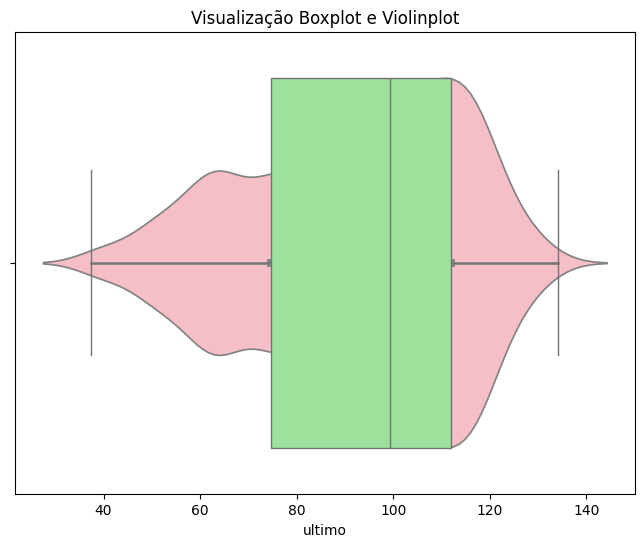

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

sns.violinplot(x='ultimo', data=df, ax=ax, color='lightpink')

sns.boxplot(x='ultimo', data=df, ax=ax, whis=1.5, color='lightgreen')
ax.set_title('Visualização Boxplot e Violinplot')

plt.show()

No gráfico acima não vemos muitos outliers, mas será se é um bom gráfico para analisar esses dados?

Text(0, 0.5, 'Valor do fechamento')

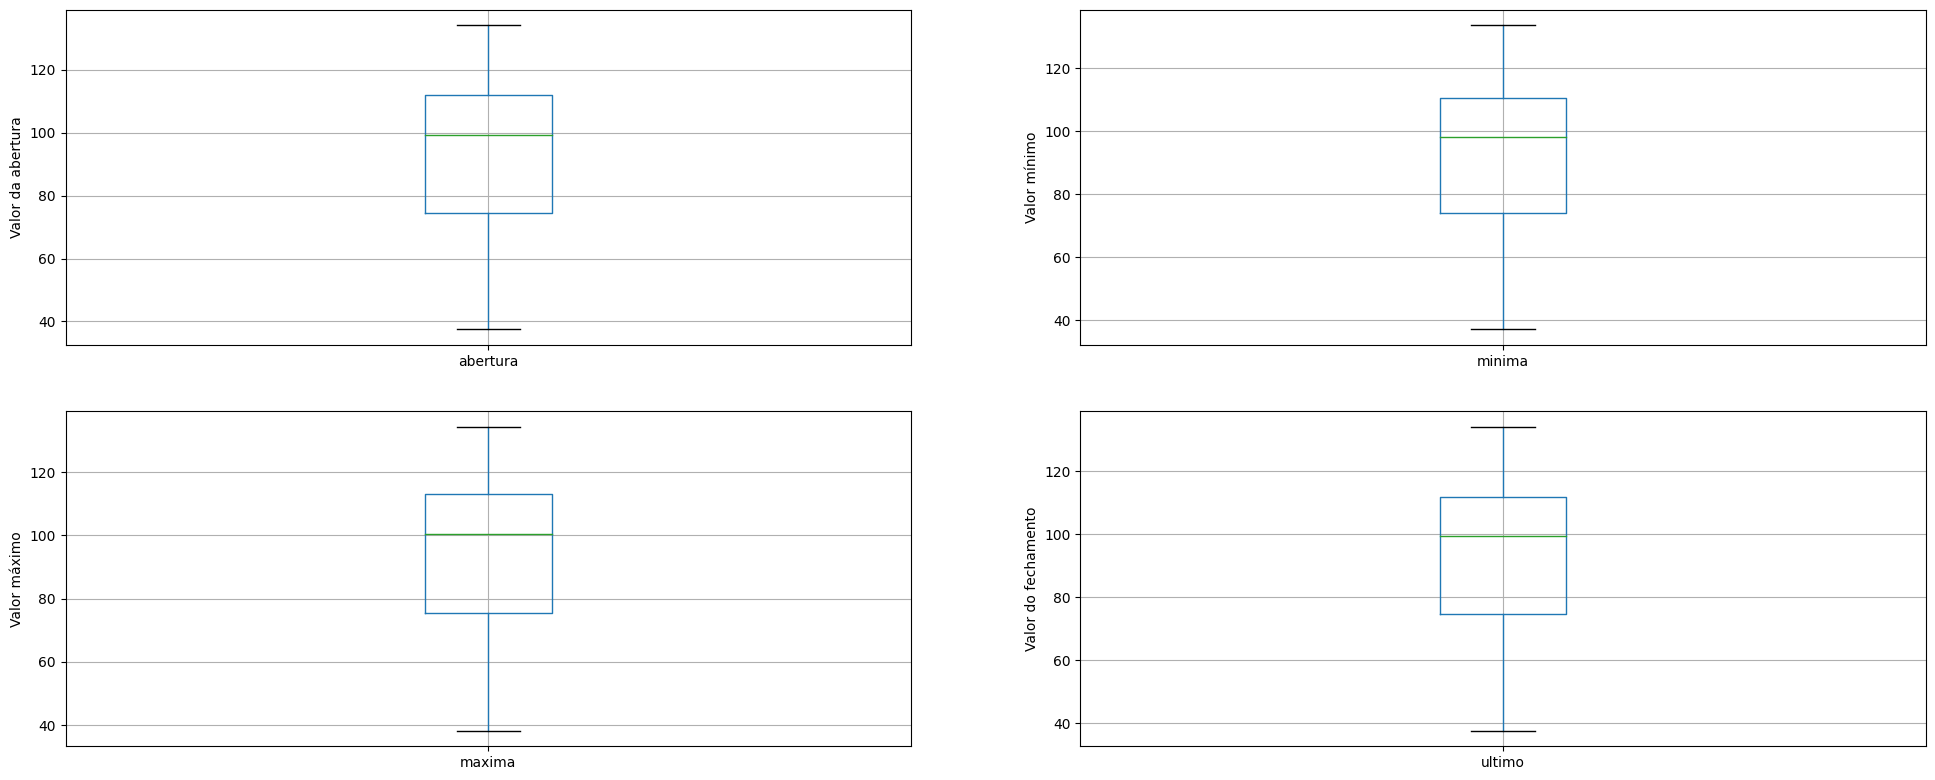

In [13]:
plt.figure(figsize=(24, 20))

plt.subplot(4, 2, 1)
fig = df.boxplot(column = "abertura")
fig.set_title("")
fig.set_ylabel("Valor da abertura")

plt.subplot(4, 2, 2)
fig = df.boxplot(column = "minima")
fig.set_title("")
fig.set_ylabel("Valor mínimo")

plt.subplot(4, 2, 3)
fig = df.boxplot(column = "maxima")
fig.set_title("")
fig.set_ylabel("Valor máximo")

plt.subplot(4, 2, 4)
fig = df.boxplot(column = "ultimo")
fig.set_title("")
fig.set_ylabel("Valor do fechamento")

<ipython-input-14-5521499a2e78>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


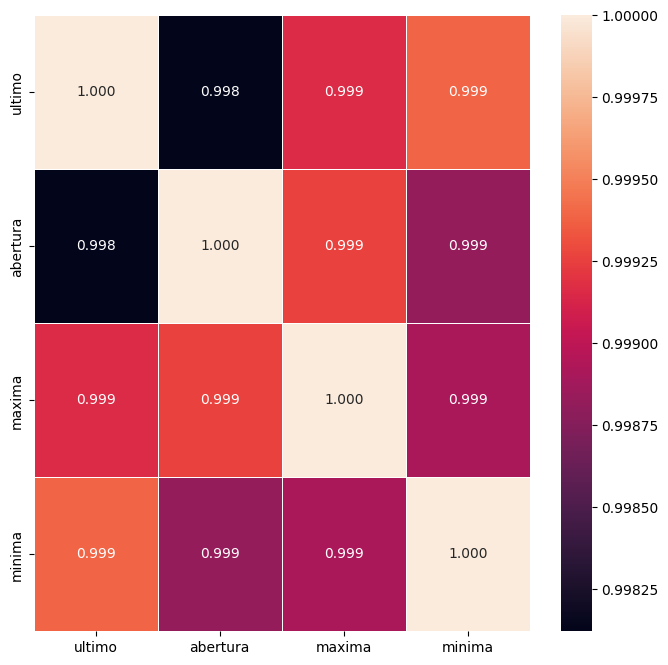

In [14]:
correlation_matrix = df.corr()

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data = correlation_matrix, annot=True, linewidth=.5, ax=ax, fmt='.3f')

plt.show()

## Ajustando a escala

In [15]:
df.head()

,data,ultimo,abertura,maxima,minima,volume,variacao
0,2023-12-28,134.185,134.194,134.389,133.832,"7,81M","-0,01%"
1,2023-12-27,134.194,133.523,134.195,133.328,"6,17M","0,49%"
2,2023-12-26,133.533,132.753,133.645,132.753,"5,15M","0,59%"
3,2023-12-22,132.753,132.182,133.035,132.094,"8,23M","0,43%"
4,2023-12-21,132.182,130.826,132.277,130.822,"8,68M","1,05%"


In [16]:
df['volume'] = df['volume'].str[:-1]

In [17]:
df['variacao'] = df['variacao'].str[:-1]

In [18]:
df['volume'] = df['volume'].str.replace(',', '.')
df['variacao'] = df['variacao'].str.replace(',', '.')

In [19]:
df.head()

,data,ultimo,abertura,maxima,minima,volume,variacao
0,2023-12-28,134.185,134.194,134.389,133.832,7.81,-0.01
1,2023-12-27,134.194,133.523,134.195,133.328,6.17,0.49
2,2023-12-26,133.533,132.753,133.645,132.753,5.15,0.59
3,2023-12-22,132.753,132.182,133.035,132.094,8.23,0.43
4,2023-12-21,132.182,130.826,132.277,130.822,8.68,1.05


In [20]:
df['volume'] = pd.to_numeric(df['volume'])
df['variacao'] = pd.to_numeric(df['variacao'])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1981 entries, 0 to 1981
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   data      1981 non-null   datetime64[ns]
 1   ultimo    1981 non-null   float64       
 2   abertura  1981 non-null   float64       
 3   maxima    1981 non-null   float64       
 4   minima    1981 non-null   float64       
 5   volume    1981 non-null   float64       
 6   variacao  1981 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 123.8 KB


In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [23]:
df = df.set_index('data')
df.head()

,ultimo,abertura,maxima,minima,volume,variacao
data,,,,,,
2023-12-28,134.185,134.194,134.389,133.832,7.81,-0.01
2023-12-27,134.194,133.523,134.195,133.328,6.17,0.49
2023-12-26,133.533,132.753,133.645,132.753,5.15,0.59
2023-12-22,132.753,132.182,133.035,132.094,8.23,0.43
2023-12-21,132.182,130.826,132.277,130.822,8.68,1.05


In [24]:
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [25]:
df_scaled.head()

,ultimo,abertura,maxima,minima,volume,variacao
0,0.999907,1.000000,1.000000,1.000000,0.006743,0.514814
1,1.000000,0.993061,0.997987,0.994793,0.005067,0.532241
2,0.993164,0.985097,0.992279,0.988852,0.004025,0.535727
3,0.985098,0.979192,0.985948,0.982043,0.007172,0.530150
4,0.979193,0.965168,0.978082,0.968900,0.007631,0.551760


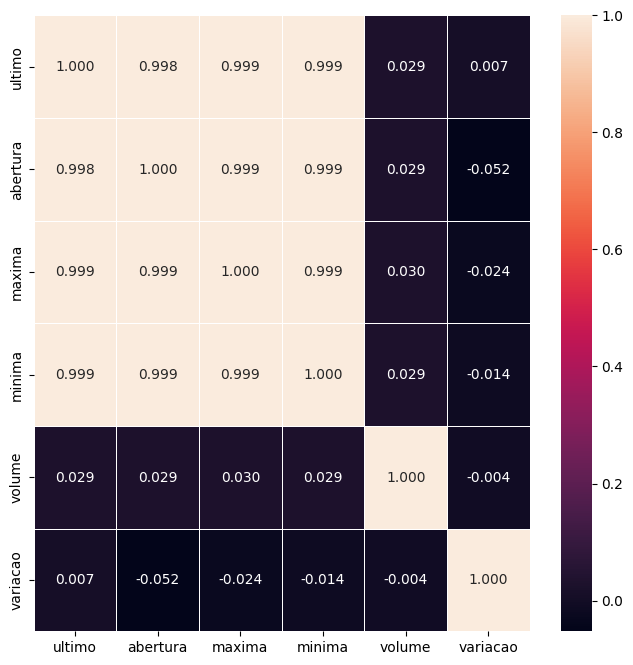

In [26]:
correlation_matrix_normalized = df_scaled.corr()

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data = correlation_matrix_normalized, annot=True, linewidth=.5, ax=ax, fmt='.3f')

plt.show()

In [27]:
df.head()

,ultimo,abertura,maxima,minima,volume,variacao
data,,,,,,
2023-12-28,134.185,134.194,134.389,133.832,7.81,-0.01
2023-12-27,134.194,133.523,134.195,133.328,6.17,0.49
2023-12-26,133.533,132.753,133.645,132.753,5.15,0.59
2023-12-22,132.753,132.182,133.035,132.094,8.23,0.43
2023-12-21,132.182,130.826,132.277,130.822,8.68,1.05


## Análise Temporal

In [28]:
df_temporal = df[['ultimo']]
df_temporal.head()

,ultimo
data,
2023-12-28,134.185
2023-12-27,134.194
2023-12-26,133.533
2023-12-22,132.753
2023-12-21,132.182


Text(0.5, 1.0, 'Valor do fechamento no decorrer dos anos')

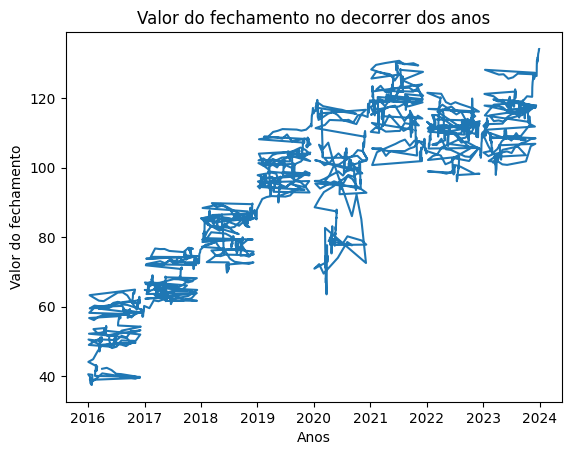

In [29]:
plt.plot(df_temporal.index, df_temporal.ultimo)
plt.xlabel('Anos')
plt.ylabel('Valor do fechamento')
plt.title('Valor do fechamento no decorrer dos anos')

In [30]:
df_temporal.index = pd.to_datetime(df_temporal.index)

In [31]:
resultados = seasonal_decompose(df_temporal, period=5)

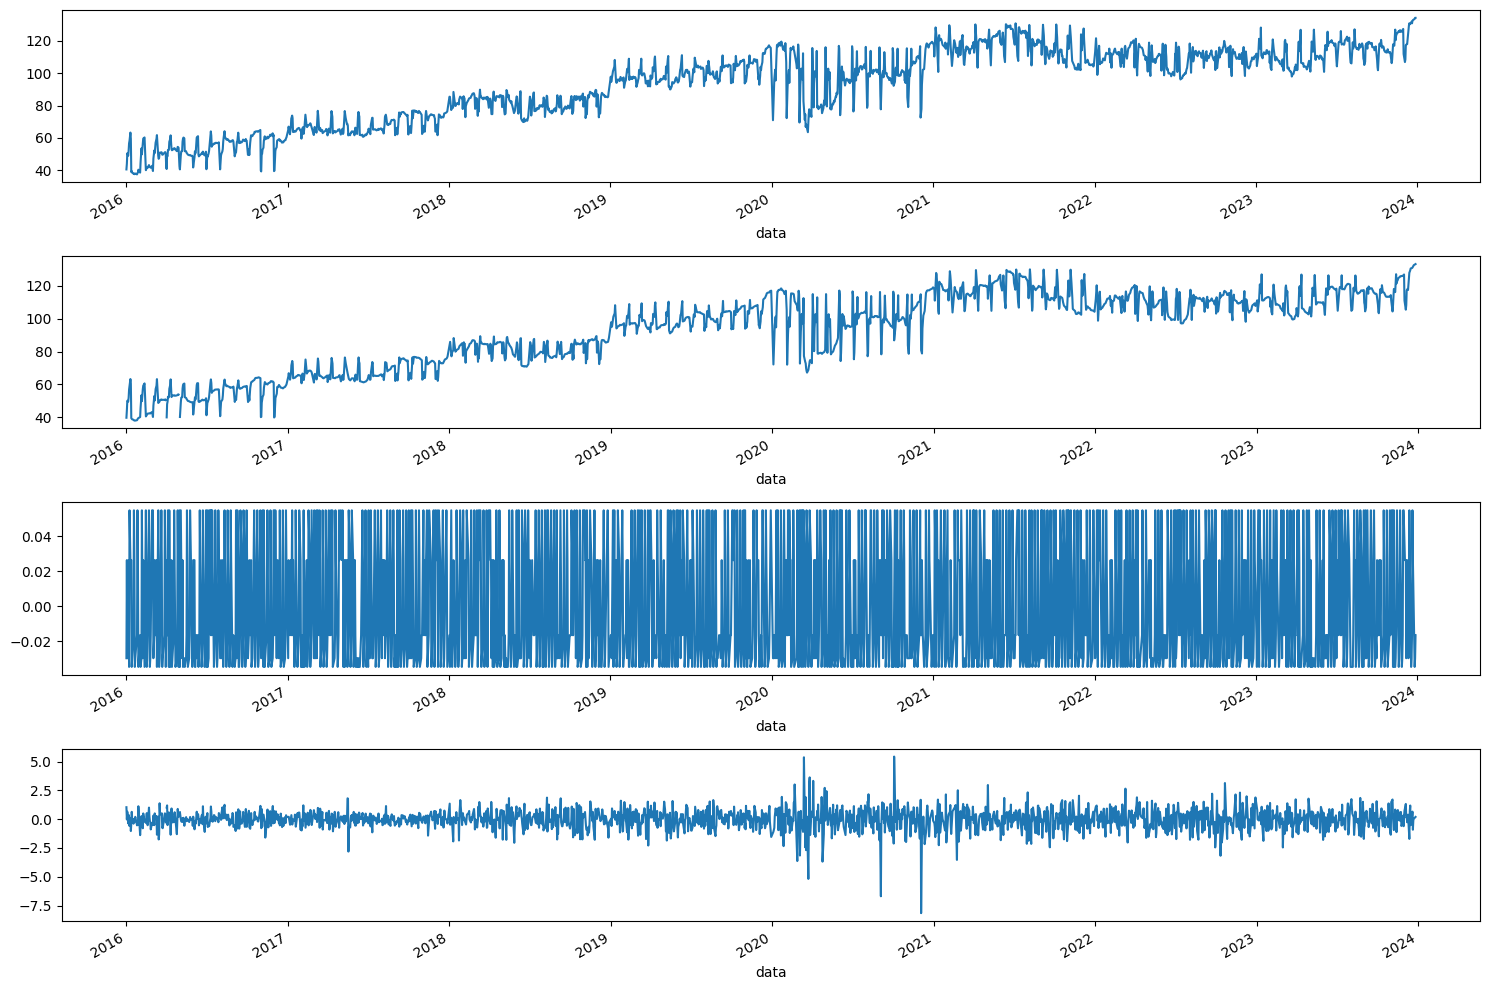

In [32]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

In [33]:
sns.set_style('darkgrid')

In [34]:
X = df_temporal.ultimo.values

In [35]:
# Estacionária ou não estacionária

# ADF - Augmented Dickey Fuller

# H0 - Hipótese Nula (não é estacionária)
# H1 - Hipótese Alternativa (rejeição da hipótese nula)

# p -value = 0.05 (5%), então rejeitamos H0 com um nível de confiança de 95%

In [36]:
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.0828561126678276
P-Value: 0.721860044620248
Valores críticos:
	1%: -3.4336704019252355
	5%: -2.863006763364656
	10%: -2.5675508440376222


O teste Augmented Dickey-Fuller (ADF) é comumente usado para verificar a estacionariedade de uma série temporal. Vamos analisar os resultados:


  **Teste Estatístico (-1.370675190740699)**: Este é o valor do teste estatístico ADF. Quanto mais negativo for esse valor, mais forte é a evidência contra a hipótese nula de que a série é não estacionária. Neste caso, o valor é negativo.

  **P-Value (0.5962512899287659)**: Este é o valor p associado ao teste estatístico. Um valor p maior que o nível de significância escolhido (por exemplo, 0.05) sugere que você não pode rejeitar a hipótese nula de que a série é não estacionária. Neste caso, o valor p é alto (0.596), sugerindo que você não pode rejeitar a hipótese nula.

  **Valores Críticos**: Esses são os valores críticos para diferentes níveis de significância (1%, 5%, 10%). Se o valor do teste estatístico for mais negativo do que esses valores críticos, você pode rejeitar a hipótese nula de que a série é não estacionária.

Em resumo, com base nos resultados fornecidos:

  1. O valor do teste estatístico é negativo, sugerindo evidência contra a hipótese nula de que a série é não estacionária.
  
  2. No entanto, o valor p é alto (0.596), indicando que você não pode rejeitar a hipótese nula a um nível de significância convencional.

Portanto, a conclusão seria que *não há evidência suficiente para rejeitar a hipótese nula de que a série temporal é não estacionária*, sugerindo que sua série pode não ser estacionária. Se você estiver buscando uma série estacionária para análises mais avançadas, pode ser necessário aplicar transformações à série ou considerar outros métodos para torná-la estacionária.

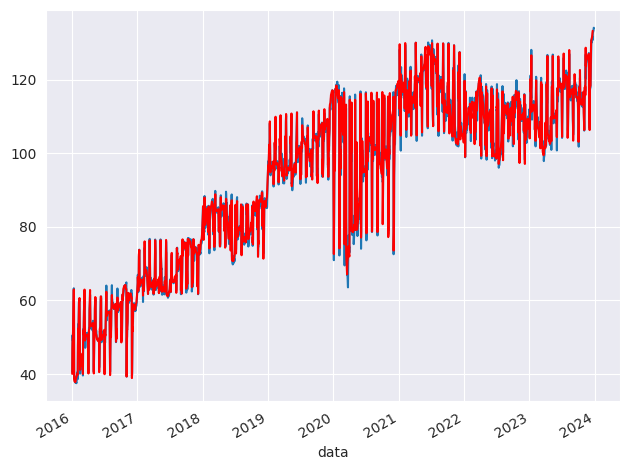

In [37]:
# média movel
ma = df_temporal.rolling(5).mean()

f, ax = plt.subplots()
df_temporal.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

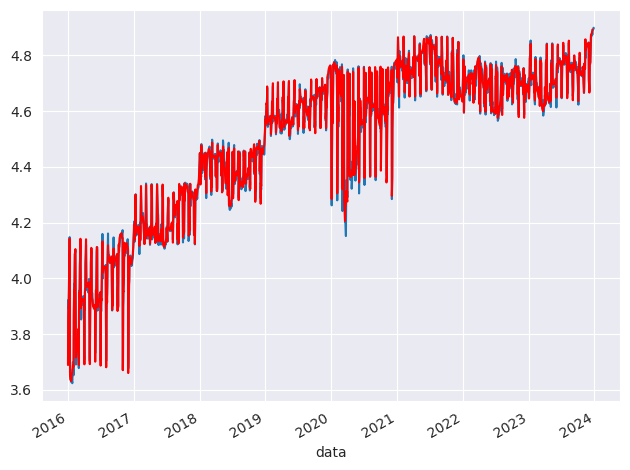

In [38]:
#transformando com log
df_log = np.log(df_temporal)
ma_log = df_log.rolling(5).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

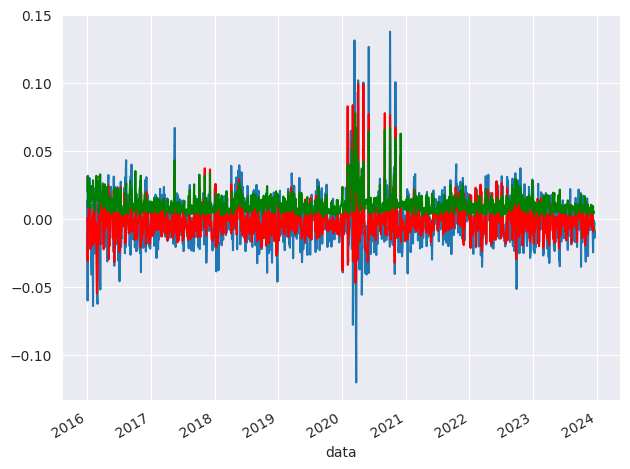

In [62]:
# subtraindo a média movel
df_s = (df_log - ma_log).dropna()

ma_s = df_s.rolling(5).mean()

std = df_s.rolling(5).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

In [40]:
X_s = df_s.ultimo.values
result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print("Valores críticos:")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -11.479436181218839
P-Value: 5.0366137339128446e-21
Valores críticos:
	1%: -3.4336771595431106
	5%: -2.863009746829746
	10%: -2.5675524325901415


Agora a série é estacionária, porque o p-valor tem o e-23, ou seja, é bem próximo de zero.

### ADF, ACF E PACF



Teste ADF
Teste Estatístico: -14.442050595057868
P-Value: 7.331887998122828e-27
Valores críticos:
	1%: -3.4337079123563106
	5%: -2.8630233240061367
	10%: -2.5675596618014462


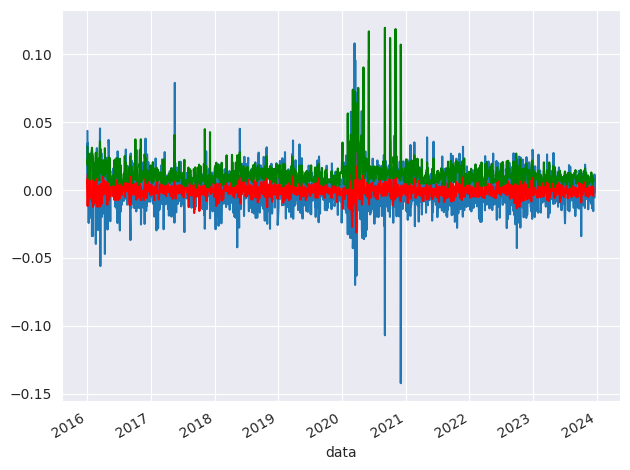

In [41]:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(5).mean()

std_diff = df_diff.rolling(5).std()


f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

X_diff = df_diff.ultimo.dropna().values
result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores críticos:")

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

In [42]:
lag_acf = acf(df_diff.dropna(), nlags=30)
lag_pacf = pacf(df_diff.dropna(), nlags=30)

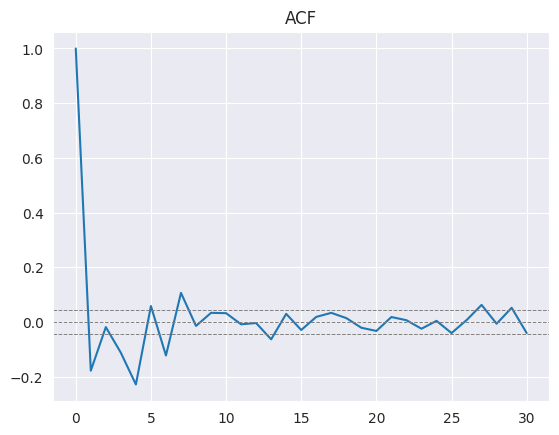

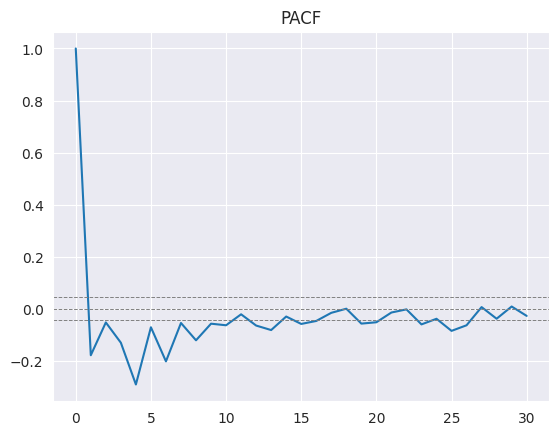

In [43]:
plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("PACF")
plt.show()

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

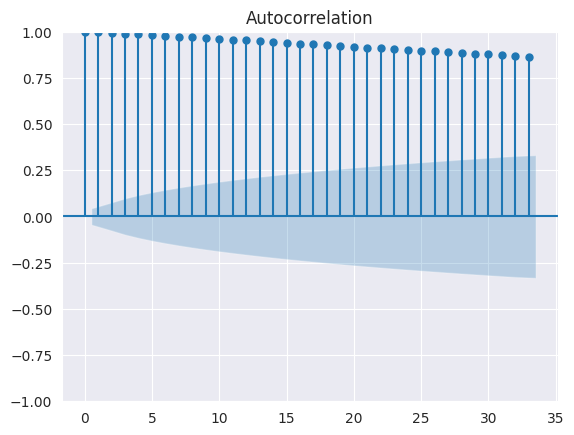

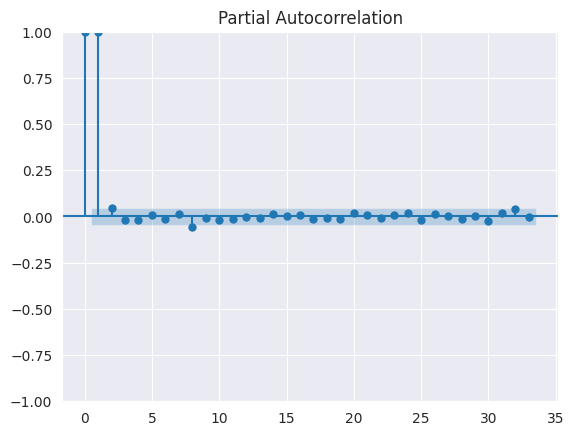

In [45]:
plot_acf(df.ultimo)
plot_pacf(df.ultimo)
plt.show()

## Arima

In [46]:
df_temporal.head()

,ultimo
data,
2023-12-28,134.185
2023-12-27,134.194
2023-12-26,133.533
2023-12-22,132.753
2023-12-21,132.182


In [47]:
df_temporal.reset_index(inplace=True)
df_temporal.head()

,data,ultimo
0,2023-12-28,134.185
1,2023-12-27,134.194
2,2023-12-26,133.533
3,2023-12-22,132.753
4,2023-12-21,132.182


In [48]:
df_1 = df_temporal[['data', 'ultimo']]
df_1 = df_1.rename(columns={'data':'ds','ultimo':'y'})

In [49]:
df_1.head()

,ds,y
0,2023-12-28,134.185
1,2023-12-27,134.194
2,2023-12-26,133.533
3,2023-12-22,132.753
4,2023-12-21,132.182


In [50]:
from statsmodels.tsa.arima.model import ARIMA

In [51]:
df_1.set_index('ds', inplace=True)

In [52]:
df_1.head()

,y
ds,
2023-12-28,134.185
2023-12-27,134.194
2023-12-26,133.533
2023-12-22,132.753
2023-12-21,132.182


In [53]:
df_1.isnull().sum()

y    0
dtype: int64

In [54]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1981 entries, 2023-12-28 to 2016-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1981 non-null   float64
dtypes: float64(1)
memory usage: 31.0 KB


In [55]:
treino = df_1.loc[df_1.index < '2022-01-31']
teste = df_1.loc[(df_1.index >= '2023-01-01')]
#train_size = int(len(df_1) * 0.8)
train, test = treino, teste

In [56]:
order = (2, 1, 2)  # Substitua p, d, q pelos valores apropriados
model = ARIMA(train, order=order)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [57]:
fit_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [58]:
predictions = fit_model.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [59]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 5255.710901465133


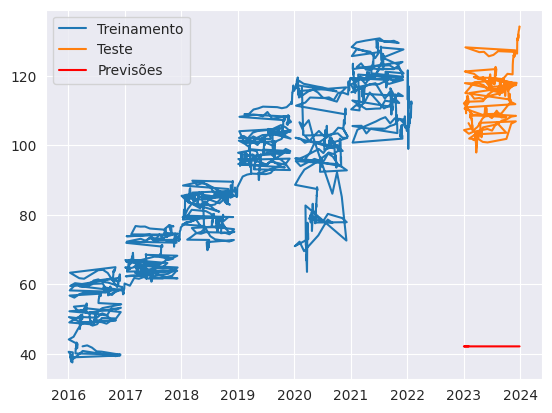

In [60]:
plt.plot(train, label='Treinamento')
plt.plot(test, label='Teste')
plt.plot(test.index, predictions, label='Previsões', color='red')
plt.legend()
plt.show()

## Prophet


In [63]:
!pip install prophet

In [64]:
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [66]:
df_prophet = df_temporal.reset_index()

In [70]:
df_prophet = df_prophet[['data', 'ultimo']]
df_prophet.head()

,data,ultimo
0,2023-12-28,134.185
1,2023-12-27,134.194
2,2023-12-26,133.533
3,2023-12-22,132.753
4,2023-12-21,132.182


In [71]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981 entries, 0 to 1980
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    1981 non-null   datetime64[ns]
 1   ultimo  1981 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.1 KB


In [72]:
split_date = pd.to_datetime('2023-01-02')

df_prophet_train = df_prophet.loc[df_prophet['data'] <= split_date].copy()
df_prophet_test = df_prophet.loc[df_prophet['data'] > split_date].copy()

In [73]:
train_prophet = df_prophet_train.reset_index() \
    .rename(columns={'data':'ds',
                     'ultimo':'y'})

In [74]:
test_prophet = df_prophet_test.reset_index() \
    .rename(columns={'data':'ds',
                     'ultimo':'y'})

In [75]:
model = Prophet()
model.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1six5mtd/j8_wh7f8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1six5mtd/nmbiyfld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57837', 'data', 'file=/tmp/tmp1six5mtd/j8_wh7f8.json', 'init=/tmp/tmp1six5mtd/nmbiyfld.json', 'output', 'file=/tmp/tmp1six5mtd/prophet_model_1n_kqqz/prophet_model-20240122232108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:21:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:21:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [76]:
prophet_test_fcst = model.predict(test_prophet)

Text(0.5, 1.0, 'Valor do fechamento ao longo dos anos')

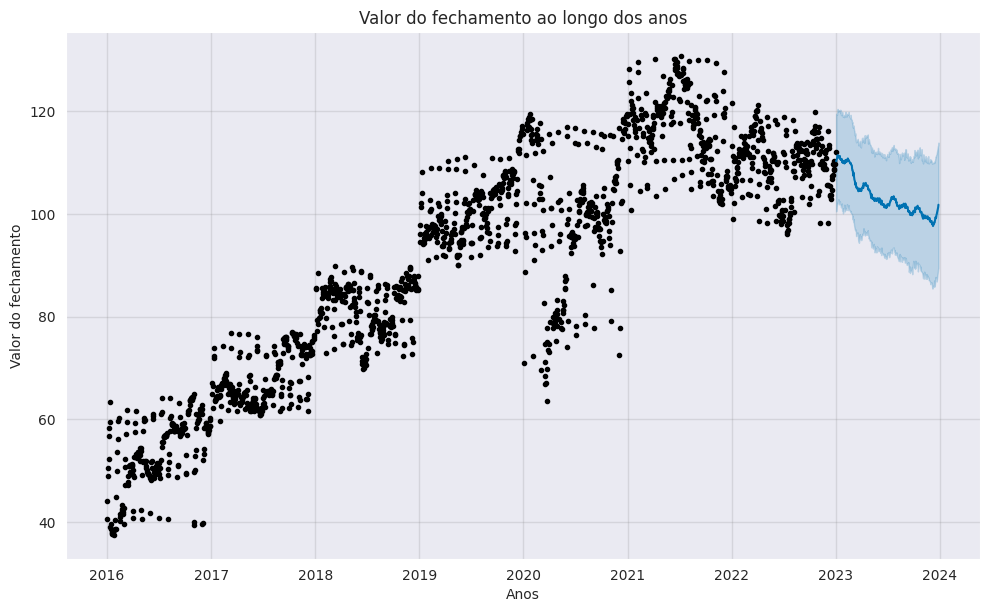

In [91]:
fig1 = model.plot(prophet_test_fcst)
plt.xlabel('Anos')
plt.ylabel('Valor do fechamento')
plt.title('Valor do fechamento ao longo dos anos')

In [79]:
indexDeTeste = df_prophet_test

indexDeTesteFcst = prophet_test_fcst

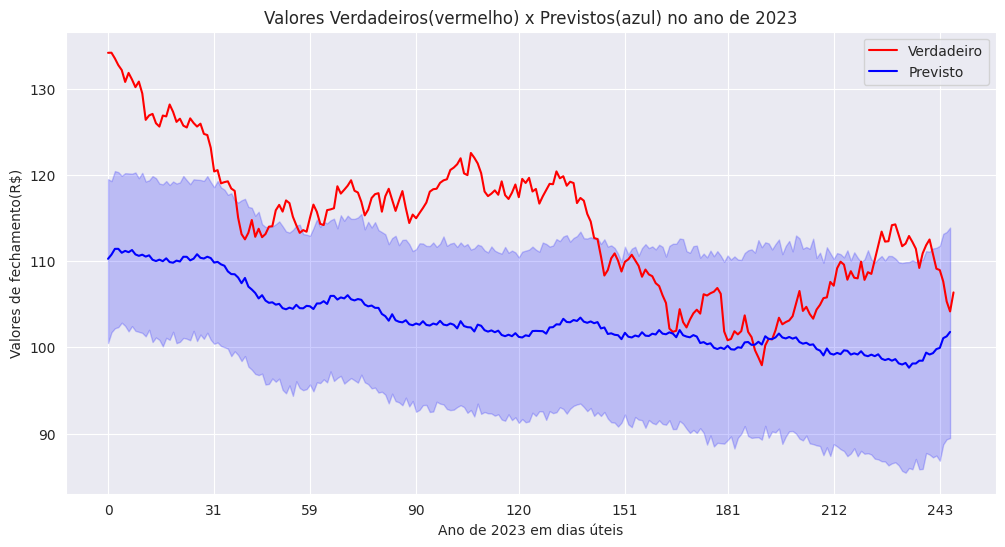

In [81]:
import matplotlib.dates as mdates

locator = mdates.MonthLocator(bymonth=[1,2,3,4,5,6,7,8,9,10,11,12])

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(indexDeTeste.index, indexDeTeste['ultimo'], label='Verdadeiro', color='red')


ax.plot(indexDeTesteFcst.index, indexDeTesteFcst['yhat'], label='Previsto', color='blue')

ax.fill_between(indexDeTesteFcst.index, indexDeTesteFcst['yhat_lower'], indexDeTesteFcst['yhat_upper'], color='blue', alpha=0.2)

plt.gca().xaxis.set_major_locator(locator)

ax.set_xlabel('Ano de 2023 em dias úteis')
ax.set_ylabel('Valores de fechamento(R$)')
ax.set_title('Valores Verdadeiros(vermelho) x Previstos(azul) no ano de 2023')
ax.legend()

plt.show()

In [85]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE: ', mean_absolute_percentage_error(y_true=df_prophet_test['ultimo'],
                   y_pred=prophet_test_fcst['yhat']))

MAPE:  9.361158813070402


In [84]:
import numpy as np

def mean_squared_error(actual, predicted):
    """
    Calculate Mean Squared Error (MSE) between actual and predicted values.

    Parameters:
    - actual: NumPy array or array-like object of actual values.
    - predicted: NumPy array or array-like object of predicted values.

    Returns:
    - Mean Squared Error (MSE).
    """
    actual = np.array(actual)
    predicted = np.array(predicted)

    if actual.shape != predicted.shape:
        raise ValueError("Shapes of actual and predicted arrays must be the same.")

    mse = np.mean((actual - predicted)**2)
    return mse

In [87]:
print('MSE: ', mean_squared_error(df_prophet_test["ultimo"], prophet_test_fcst["yhat"]))

MSE:  151.58522290681412


<Axes: xlabel='ds', ylabel='y'>

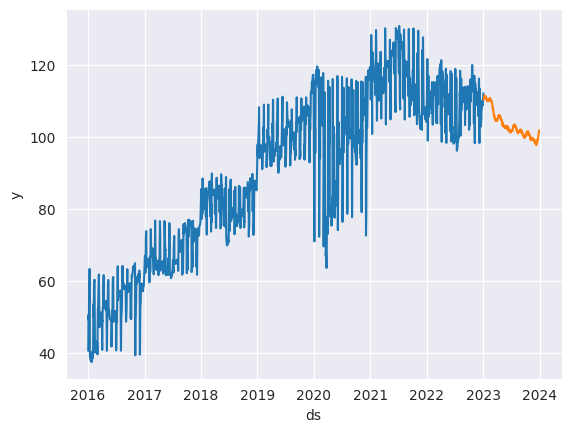

In [88]:
sns.lineplot(x='ds', y='y', data=train_prophet)
sns.lineplot(x='ds', y='yhat', data=prophet_test_fcst)

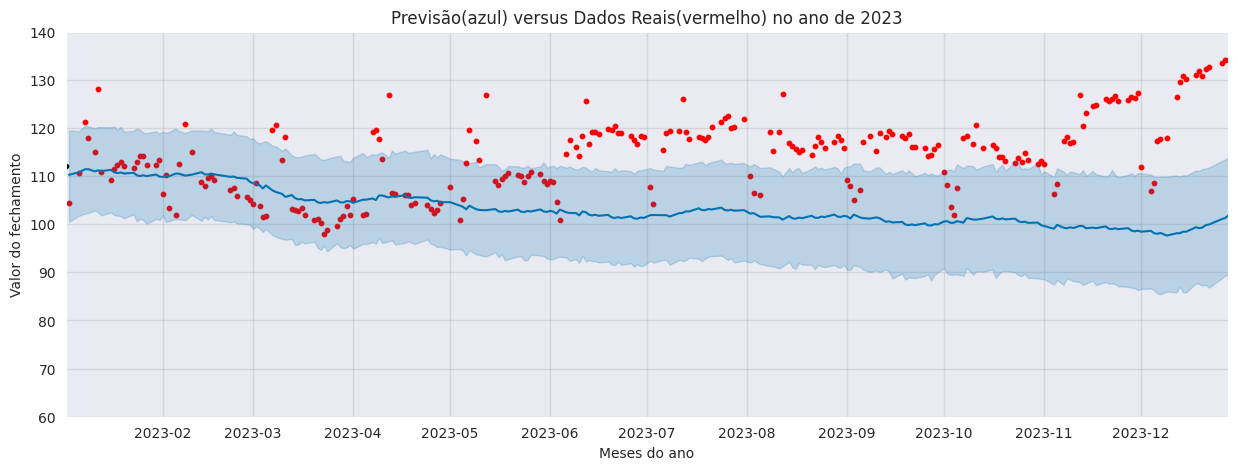

In [92]:
import datetime
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_prophet_test['data'], df_prophet_test['ultimo'], color='r', s=10)
fig = model.plot(prophet_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.datetime.strptime('2023-01-02', '%Y-%m-%d'), upper=datetime.datetime.strptime('2023-12-28', '%Y-%m-%d'))
ax.set_ylim(60, 140)
ax.set_title('Previsão(azul) versus Dados Reais(vermelho) no ano de 2023')
plt.xlabel('Meses do ano')
plt.ylabel('Valor do fechamento')
plt.show()